# Experiment notebook for "Context is All You Need"
In this notebook we conduct experiments involving few-shot fine-tuning, in-context learning (ICL), and a novel implementation of context distillation.

To install the development environment, run the following:
```
conda env create -f environment.yml
conda activate fine-tuning
```

Run ```pip install -e .``` if module importing isn't working.

In [1]:
%load_ext autoreload
%autoreload 2

If the check below fails, verify your pytorch installation by following the steps at https://pytorch.org/get-started/locally/.

In [2]:
from src.utils import cuda_check

cuda_check()

Cuda available: True


### Import datasets

Import datasets using methods from `src/data/data.py`. Datasets are downloaded from huggingface and stored in `/data`. Once downloaded, datasets are loaded locally.

Our in domain dataset is [MNLI](https://huggingface.co/datasets/glue). Our out of domain dataset is [HANS](https://huggingface.co/datasets/hans).

In [3]:
import pprint
from src.data.data import get_in_domain, get_out_domain

in_domain_train, in_domain_test = get_in_domain()
out_domain = get_out_domain()

print(f"In domain (MNLI):\n{in_domain_train}")
pprint.pprint(in_domain_train[1])

print(f"\nOut of domain (HANS):\n{out_domain}")
pprint.pprint(out_domain[10])

In domain (MNLI):
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261802
})
{'hypothesis': 'A member of my team will execute your orders with immense '
               'precision.',
 'idx': 2,
 'label': 0,
 'premise': 'One of our number will carry out your instructions minutely.'}

Out of domain (HANS):
Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 10000
})
{'binary_parse_hypothesis': '( ( The athlete ) ( ( avoided ( the president ) ) '
                            '. ) )',
 'binary_parse_premise': '( ( The president ) ( ( avoided ( the athlete ) ) . '
                         ') )',
 'heuristic': 'lexical_overlap',
 'hypothesis': 'The athlete avoided the president .',
 'label': 1,
 'parse_hypothesis': '(ROOT (S (NP (DT The) (NN athlete)) (VP (VBD avoided) '
                     '(NP (DT the) (NN president

### Create training and evaluation datasets

The `get_random_subsets` method from `src/data/data.py` creates a dictionary of training and evaluation data organized by sample size. Each sample size will contain 10 randomly generated trials of that sample size. Evaluation sets contain 50 samples and are randomly generated a single time to ensure consistant comparison across fine-tuning methods.

Before generating our datasets, we set random seeds to ensure reproducibility.

In [4]:
import numpy as np
import random
from src.data.data import get_random_subsets

# Seed random generators
seed = 42
np.random.seed(seed)
random.seed(seed)

# Generate training and evaluation datasets
train_datasets, eval_dataset_in, eval_dataset_out = get_random_subsets(train_dataset=in_domain_train, 
                                                                       eval_dataset_in=in_domain_test, 
                                                                       eval_dataset_out=out_domain, 
                                                                       train_sample_sizes=[2, 4, 8, 16],
                                                                       num_trials=10,
                                                                       eval_sample_size=50)

print("Train datasets:")
pprint.pprint(train_datasets, depth=1)
print("\nEval datasets:")
pprint.pprint(eval_dataset_in, depth=1)
pprint.pprint(eval_dataset_out, depth=1)

Train datasets:
{2: [...], 4: [...], 8: [...], 16: [...]}

Eval datasets:
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 50
})
Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 50
})


### Import models

Import models using methods from `src/models/opt.py`. Models are downloaded from huggingface and stored in `/models/pretrained`. Once downloaded, models are loaded locally. In the following experiments, model loading is handled in the scope of each fine-tuning method.

In [5]:
# from src.model.model import get_model

# # Get SequenceClassification models
# model_opt125, tokenizer_opt125 = get_model(model_name='opt-125m', model_type='SequenceClassification', pretrained=True)
# model_opt350, tokenizer_opt350 = get_model(model_name='opt-350m', model_type='SequenceClassification', pretrained=True)

# # Get CasualLM models
# model_opt125_causal, tokenizer_opt125_causal = get_model(model_name='opt-125m', model_type='CausalLM', pretrained=True)
# model_opt350_causal, tokenizer_opt350_causal = get_model(model_name='opt-350m', model_type='CausalLM', pretrained=True)

### Zero-shot baseline

We evaluate both models on in and out of domain eval sets with no training or context using the `generate` method. These results serve as a baseline for comparison to other fine-tuning methods. Model parameters are not updated using this method.

In [7]:
from src.finetuners.zeroshot import batch_evaluate

metrics = batch_evaluate(model_names=['opt-125m', 'opt-350m'], 
                         eval_dataset_in=eval_dataset_in, 
                         eval_dataset_out=eval_dataset_out, 
                         exp_label='final')

print("Metrics:")
pprint.pprint(metrics)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

Metrics:
{'eval_in_accuracy': 0.56,
 'eval_in_loss': 0.7520318841934204,
 'eval_in_peak_memory_gb': 8.716383934020996,
 'eval_in_runtime': 45.67260932922363,
 'eval_in_samples_per_second': 1.0947480499654196,
 'eval_out_accuracy': 0.52,
 'eval_out_loss': 0.6991815215349197,
 'eval_out_peak_memory_gb': 8.716383934020996,
 'eval_out_runtime': 48.564321517944336,
 'eval_out_samples_per_second': 1.0295624120173323,
 'model_name': 'opt-350m',
 'sample_size': '50'}


### Few-shot fine-tuning

We fine-tune both models on 10 trials of training data and evaluate on in and out of domain eval sets. This method updates all model parameters. Fine-tuned models can be saved locally to `models/finetuned/` by setting the `save_trials` parameter to `True`.

In [5]:
from src.finetuners.fewshot import batch_fine_tune

metrics, training_histories = batch_fine_tune(model_names=['opt-125m', 'opt-350m'], 
                                              train_datasets=train_datasets, 
                                              eval_dataset_in=eval_dataset_in, 
                                              eval_dataset_out=eval_dataset_out, 
                                              exp_label='final', 
                                              save_trials=False)

#print("Metrics:")
#pprint.pprint(metrics)
#print("Training histories:")
#pprint.pprint(training_histories)

opt-125m 2-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-125m 4-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-125m 8-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-125m 16-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 2-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 4-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 8-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 16-shot:   0%|          | 0/10 [00:00<?, ?it/s]

### Few-shot with LoRA (Low Rank Adaptation)

We fine-tune both models identically to few-shot fine-tuning, but with each model converted to a `LoraModel` for Parameter-Efficient Fine-tuning (PEFT).

In [8]:
from src.finetuners.fewshot_lora import batch_fine_tune

metrics, training_histories = batch_fine_tune(model_names=['opt-125m', 'opt-350m'], 
                                              train_datasets=train_datasets, 
                                              eval_dataset_in=eval_dataset_in, 
                                              eval_dataset_out=eval_dataset_out, 
                                              exp_label='final', 
                                              save_trials=False)

#print("Metrics:")
#pprint.pprint(metrics)
#print("Training histories:")
#pprint.pprint(training_histories)

opt-125m 2-shot:   0%|          | 0/10 [00:00<?, ?it/s]

trainable params: 167424 || all params: 125389824 || trainable%: 0.13%


opt-125m 4-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-125m 8-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-125m 16-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 2-shot:   0%|          | 0/10 [00:00<?, ?it/s]

trainable params: 443392 || all params: 331591680 || trainable%: 0.13%


opt-350m 4-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 8-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 16-shot:   0%|          | 0/10 [00:00<?, ?it/s]

### In-context learning (ICL)

ICL is performed similarly to zero-shot evaluation, using the `generate` method. Context (labeled training examples) is pre-pended to each evaluation example. Model parameters are not updated using this method.

In [7]:
from src.finetuners.incontext import batch_evaluate

metrics = batch_evaluate(model_names=['opt-125m', 'opt-350m'], 
                         train_datasets=train_datasets, 
                         eval_dataset_in=eval_dataset_in, 
                         eval_dataset_out=eval_dataset_out, 
                         exp_label='final')

#print("Metrics:")
#pprint.pprint(metrics)

opt-125m 2-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-125m 4-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-125m 8-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-125m 16-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 2-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 4-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 8-shot:   0%|          | 0/10 [00:00<?, ?it/s]

opt-350m 16-shot:   0%|          | 0/10 [00:00<?, ?it/s]

### Context-distillation fine-tuning
TODO: add description

In [ ]:
from src.finetuners.context_distillation import batch_context_distillation
from src.data.data import get_context_distillation_datasets

context_distillation_datasets = get_context_distillation_datasets(dataset=in_domain_train,
                                                                  train_datasets=train_datasets,
                                                                  fewshot_sample_size=16,
                                                                  large_sample_size=4096)

metrics = batch_context_distillation(model_names=['opt-125m', 'opt-350m'],
                                     in_domain_dataset=in_domain_train,
                                     train_datasets=context_distillation_datasets,
                                     eval_dataset_in=eval_dataset_in,
                                     eval_dataset_out=eval_dataset_out,
                                     exp_label='final')

print("Metrics:")
pprint.pprint(metrics)

opt-125m 16-shot:   0%|          | 0/5 [00:00<?, ?it/s]

opt-125m 4096-shot:   0%|          | 0/1025 [00:00<?, ?it/s]

opt-350m 16-shot:   0%|          | 0/9 [00:00<?, ?it/s]

opt-350m 4096-shot:   0%|          | 0/2049 [00:00<?, ?it/s]

Metrics:
None


### Recursive context-distillation fine-tuning
TODO: add description

In [6]:
from src.finetuners.context_distillation_recursive import batch_recursive_context_distillation
from src.data.data import get_context_distillation_datasets

context_distillation_datasets = get_context_distillation_datasets(dataset=in_domain_train,
                                                                  train_datasets=train_datasets,
                                                                  fewshot_sample_size=16,
                                                                  large_sample_size=4096)

metrics = batch_recursive_context_distillation(model_names=['opt-125m', 'opt-350m'],
                                     in_domain_dataset=in_domain_train,
                                     train_datasets=context_distillation_datasets,
                                     eval_dataset_in=eval_dataset_in,
                                     eval_dataset_out=eval_dataset_out,
                                     exp_label='final')

print("Metrics:")
pprint.pprint(metrics)

opt-125m 16-shot:   0%|          | 0/5 [00:00<?, ?it/s]

opt-125m 4096-shot:   0%|          | 0/1025 [00:00<?, ?it/s]

opt-350m 16-shot:   0%|          | 0/9 [00:00<?, ?it/s]

opt-350m 4096-shot:   0%|          | 0/2049 [00:00<?, ?it/s]

Metrics:
None


### Plot in-domain vs. out-of-domain metrics

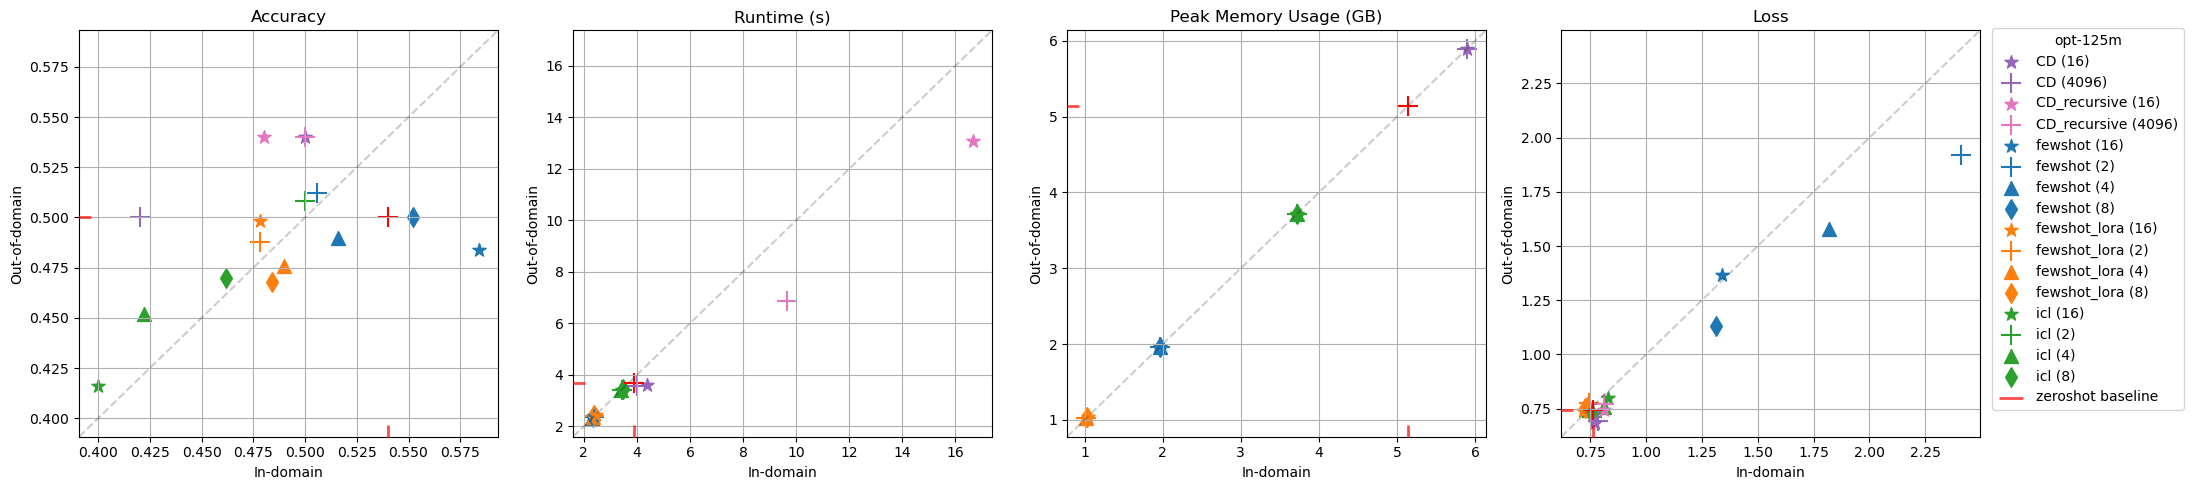

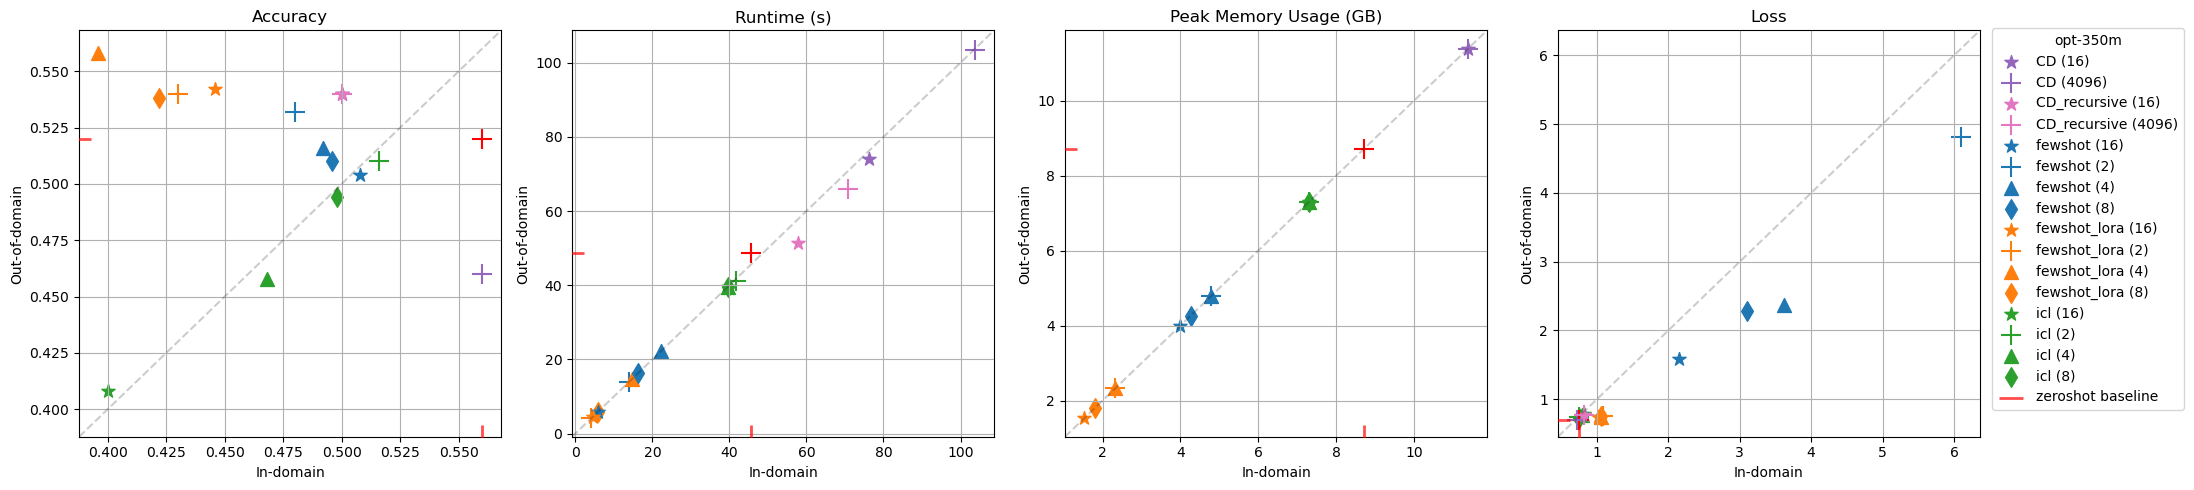

In [3]:
from src.visualization.plot import plot_in_out_domain_subplots

plot_in_out_domain_subplots(logfiles=['fewshot_metrics_final.csv',
                                      'icl_metrics_final.csv',
                                      'zeroshot_metrics_final.csv',
                                      'fewshot_lora_metrics_final.csv',
                                      'context_distillation_metrics_final.csv',
                                      'recursive_context_distillation_metrics_final.csv'],
                            metrics=['accuracy', 'runtime', 'peak_memory_gb', 'loss'],
                            group_by='model_name')

### Plot learning curves

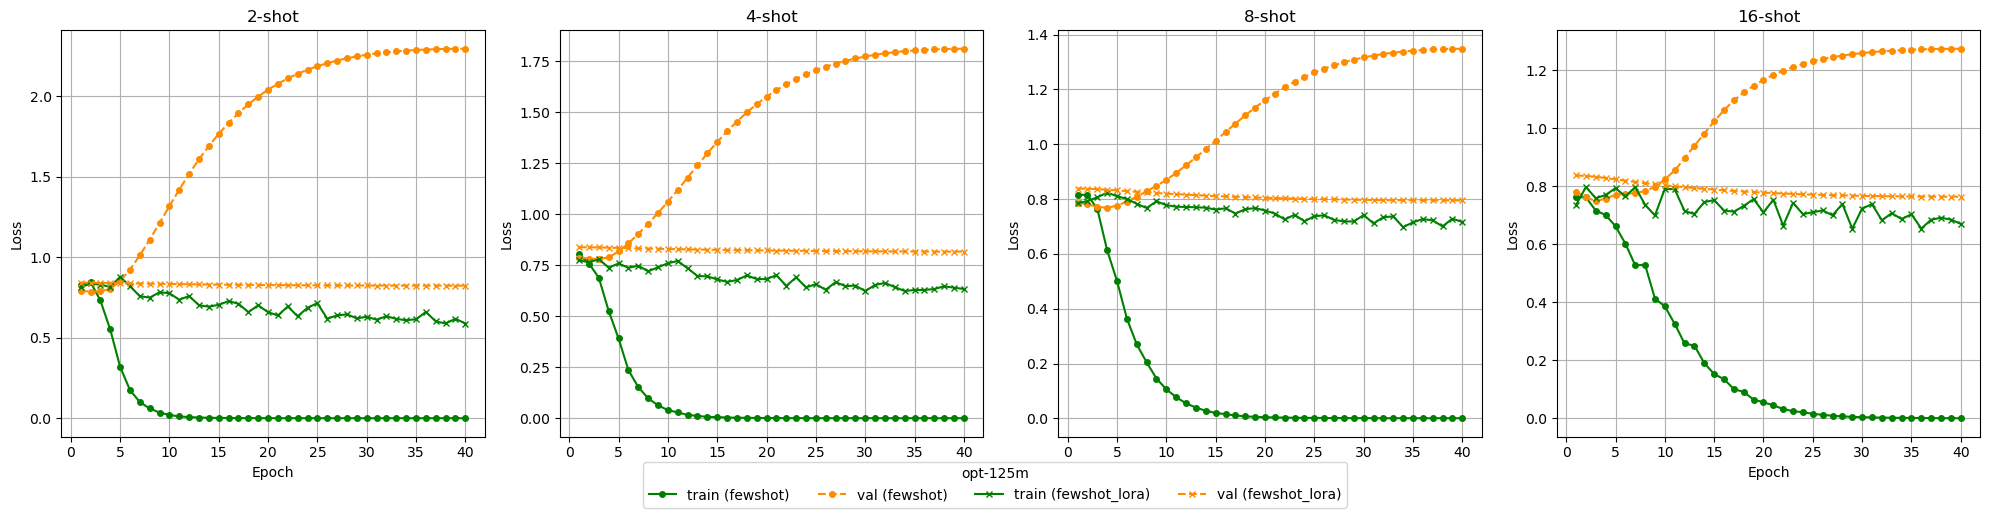

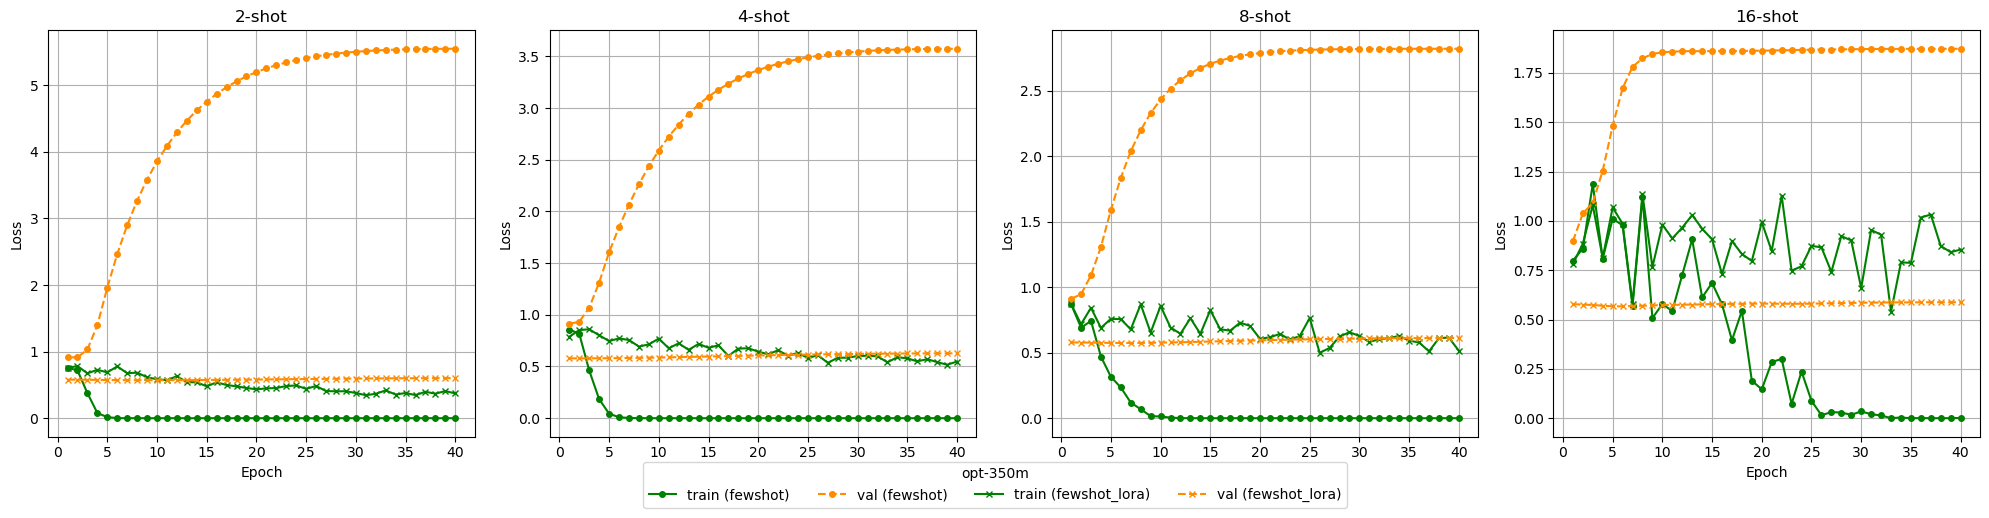

In [4]:
from src.visualization.plot import plot_learning_curves

plot_learning_curves(logfiles=['fewshot_training_history_final.csv',
                               'fewshot_lora_training_history_final.csv'], 
                     subplot=True)